#Тестовое задание на ставку специалиста по машинному обучению
**Цель**:

Построение однослойного персептрона, согласно правилу:

$f(x, y) = 
\begin{cases}
   1 ,&\frac{1}{2}x+\frac{1}{2}y\geq0.6\\
   0 ,&\frac{1}{2}x+\frac{1}{2}y<0.6\\
\end{cases}$

**Задачи**: 

1. Реализовать алгоритм создания тестовой и обучающей выборок (точек двумерного 
пространства)
2. Построить конфигурацию сети (2 входных нейрона и один выходной нейрон)
3. Проинициализировать веса сети случайными малыми значениями. Ошибка $E = 0$, итерация  $= 1$
4. Реализовать алгоритм обучения простого однослойного персептрона
5. Произвести обучение нейронной сети, используя в качестве активационной функции $sign(x)$
6. Реализовать логирования процесса обучения сети (пороговое значение, ошибка и текущие значения весов на итерацию), используя обучающую выборку
7. Произвести проверку сети, используя тестовую выборку и функцию, указанную выше. Предусмотреть логирование процесса логирования.

**Дополнительные задачи** (не обязательно, но будет плюсом):
1. Реализация параллельного обучения сети
2. Реализация графического отображения matplotlib



**Примечания**:
* Показать принципы ООП в построении в конфигурации сети (Сущность нейрона, сети, входного вектора)
* Не использовать сторонние решения с нейронными сетями (tensorFlow, keras и пр.)
* Допускается использование numpy по необходимости


#Реализация задания

In [1]:
import numpy as np
from matplotlib.pyplot import *

Алгоритмы создания тестовой и обучающей выборки

In [2]:
def get_test_set(amount, inf=-2, sup=2):
    return np.array([[np.random.uniform(inf,sup), np.random.uniform(inf,sup)] for i in range(amount)])

def get_training_set(amount,inf=-2, sup=2):
    inputs, outputs = [], []
    for i in range(amount):
        x = np.random.uniform(inf,sup)
        y = np.random.uniform(inf,sup)
        inputs += [[x, y]]
        outputs += [1 if x + y >= 1.2 else 0]
    return inputs, outputs

Различные функции активации и их производные

In [3]:
def sigmo(z):
    return 1/(1+np.exp(-z))

def dsigm(z):
    return np.exp(-z)/(1+np.exp(-z)**2)

def sign(x):
    return np.sign(x)

def dsign(x):
    a=0.1
    return np.exp(-(x/a)**2)/(a*np.pi)

Класс нейрона

In [4]:
class Neuron:
    def __init__(self, number_of_inputs, activation_function, activation_function_derivative, neuron_type='Simple'):
        self.number_of_inputs = number_of_inputs
        self.weights = [1] if neuron_type=='Input' else np.random.rand(number_of_inputs)
        self.inputs = [0 for i in range(number_of_inputs)]
        self.output = 0
        self.f = activation_function
        self.df = activation_function_derivative
        self.neuron_type = neuron_type
        self.delta = .0
    
    def __str__(self):
        return (f"      Weights: {list(self.weights)}\n" +
               f"      Inputs: {self.inputs}\n"+
               f"      Sum: {self.get_sum()}; Output: {self.output}\n")
    
    def get_sum(self):
        return sum([self.inputs[i]*self.weights[i] for i in range(self.number_of_inputs)])
    
    def feed_forward(self, inputs):
        self.inputs = inputs[:]
        self.output = self.get_sum() if self.neuron_type == 'Input' else self.f(self.get_sum())
        return self.output
    
    def learn(self, error, learningRate):
        if self.neuron_type == 'Input':
            return
        self.delta = error * self.df(self.get_sum())
        self.weights = [self.weights[i] - self.inputs[i] * self.delta * learningRate for i in range(self.number_of_inputs)]
        return self.weights

Класс слоя нейронной сети

In [5]:
class Layer:
    def __init__(self, neurons, neurons_type='Simple'):
        for neuron in neurons:
            if neuron.neuron_type != neurons_type:
              return
        self.neurons = neurons[:]
        self.neuron_count = len(neurons)
        self.neurons_type = neurons_type
    
    def __str__(self):
        result = ""
        for i in range(len(self.neurons)):
            result += f'    Neuron {i+1}:\n{str(self.neurons[i])}'
        return result
    
    def get_outputs(self):
        return [neuron.output for neuron in self.neurons]
    
    def get_weights(self):
        return [neuron.weights for neuron in self.neurons]
    
    def get_sums(self):
        return [neuron.get_sum() for neuron in self.neurons]
    

Класс самой нейронной сети

In [6]:
class Perceptron:

    def __init__(self, input_length, output_length, hidden_layers_lengths,
                 learning_rate, activation_fuction, activation_function_derivative):
        self.learning_rate = learning_rate
        self.f = activation_fuction
        self.df = activation_function_derivative
        self.create_layers(input_length, output_length, hidden_layers_lengths)
        log_file = open('log.txt', 'w')
        log_file.close()
    
    def __str__(self):
        result = ""
        for i in range(len(self.layers)):
            result += f'  Layer {i+1}:\n{str(self.layers[i])}'
        return result
    
    def create_layers(self, input_length, output_length, hidden_layers_lengths):
        self.layers = []
        input_layer = Layer([Neuron(1, self.f, self.df, "Input") for i in range(input_length)], "Input")
        self.layers += [input_layer]

        for layer_length in hidden_layers_lengths:
            hidden_layer = Layer([Neuron(self.layers[-1].neuron_count, self.f, self.df) for i in range(layer_length)])
            self.layers += [hidden_layer]
        
        output_layer = Layer([Neuron(self.layers[-1].neuron_count, self.f, self.df, "Output") for i in range(output_length)], "Output")
        self.layers += [output_layer]

    def set_inputs(self, inputs):
        for neuron, input in zip(self.layers[0].neurons, inputs):
            neuron.feed_forward([input])
    
    def feed_forward(self):
        for i in range(1, len(self.layers)):
            for neuron in self.layers[i].neurons:
                neuron.feed_forward(self.layers[i-1].get_outputs())
    
    def write_weights(self, weights : dict):
        for i in range(len(self.layers)):
              if not(i in weights.keys()):
                  weights[i] = dict()
              layer_weights = self.layers[i].get_weights()
              for j in range(len(self.layers[i].neurons)):
                  if not(j in weights[i].keys()):
                      weights[i][j] = dict()
                  for k in range(len(self.layers[i].neurons[j].weights)):
                    if not(k in weights[i][j].keys()):
                        weights[i][j][k] = []
                    weights[i][j][k] += [layer_weights[j][k]]
    
    def write_to_log(self, data):
        with open('log.txt', 'a') as ouf:
            ouf.write(data)
    
    def read_log(self):
        log_file = open('log.txt', 'r')
        lines = log_file.readlines()
        for line in lines:
            print(line, end='')

    def learn(self, inputs, train_data, epoches):
        errors = []
        weights = dict()
        for epoch in range(epoches):
          error = 0.0
          for o in range(len(train_data)):
              e = self.backpropagation(inputs[o], train_data[o])
              error += e
          self.write_weights(weights)
          errors += [error/2]
          self.write_to_log(f'______Epoch {epoch+1}______\nError={error}\nNetwork State:\n{self.__str__()}\n')
        return errors, weights

    def predict(self, inputs):
        self.set_inputs(inputs)
        self.feed_forward()
        return max(self.layers[-1].neurons, key=lambda neuron: neuron.output).output
    
    def backpropagation(self, inputs, train_data):
        diff = self.predict(inputs) - train_data

        for neuron in self.layers[-1].neurons:
            neuron.learn(diff, self.learning_rate)
        
        for j in range(len(self.layers)-2, 0, -1):
            layer = self.layers[j]
            previous_layer = self.layers[j + 1]

            for i in range(len(layer.neurons)):
                neuron = layer.neurons[i]
                for k in range(len(previous_layer.neurons)):
                    previous_neuron = previous_layer.neurons[k]
                    error = previous_neuron.weights[i] * previous_neuron.delta
                    neuron.learn(error, self.learning_rate)

        return diff ** 2


#Проверка работы сети

Создание простого перцептрона, с двумя входными нейронами, одним скрытым слоем с двумя нейронами, и одним выходным нейроном. Скорость обучения равна 0.4. В качестве функции активации взята сигмоида, т.к. применение сигнума в сетях, обучающихся методом обратного распространения ошибки не приведёт к обучению, т.к. произвводна от сигнума (двойная дельта-функция Дирака) равна нулю на всём множестве чисел, кроме 0.

In [7]:
P = Perceptron(2, 1, [2], .4, sigmo, dsigm)
training_set_size = 1000
inputs, outputs = get_training_set(training_set_size, -2, 2)

Обучение перцептрона и построение графика зависимости ошибки от эпохи

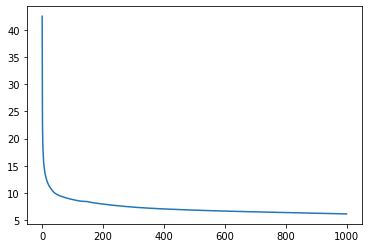

In [8]:
epoches = 1000
es, weights = P.learn(inputs, outputs, epoches)
plot(es)
show()

Построение графиков зависимостей весов нейронов от эпохи

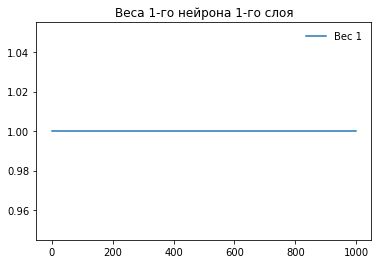

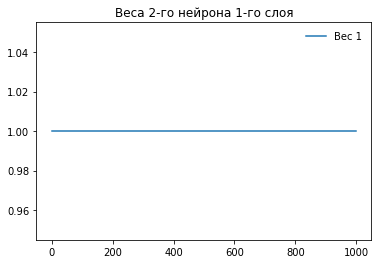

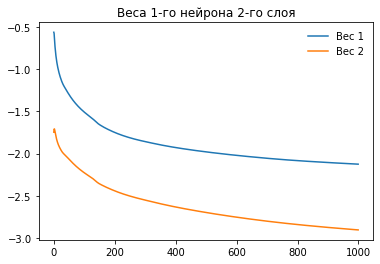

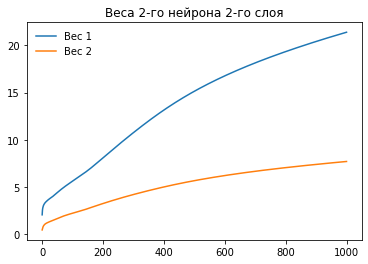

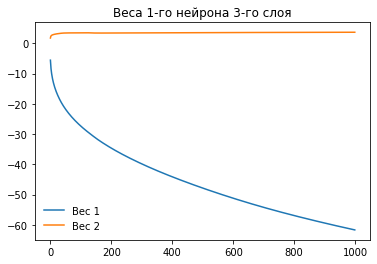

In [9]:
for i in range(len(weights)):
    for j in range(len(weights[i])):
      for k in range(len(weights[i][j])):
        plot(weights[i][j][k], label=f'Вес {k+1}')
      title(f'Веса {j+1}-го нейрона {i+1}-го слоя')
      legend(frameon=False)
      show()

Визуализация тестовой выборки и результата работы перцептрона

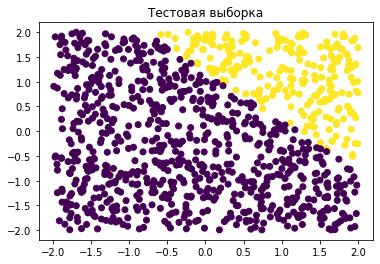

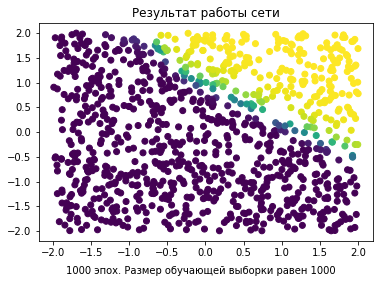

In [10]:
inputs1, outputs1 = get_training_set(1000, -2,2)

xs, ys, ous = [], [], []

for i in range(1000):
  xs += [inputs1[i][0]]
  ys += [inputs1[i][1]]
  ous += [P.predict(inputs1[i])]

scatter(xs, ys, c=outputs1)
title('Тестовая выборка')
show()
title(f'Результат работы сети')
scatter(xs, ys, c=ous)
figtext(0.5, 0.01, f"{epoches} эпох. Размер обучающей выборки равен {training_set_size}", ha="center")
show()